In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as inter
from scipy import optimize as opt
plt.rcParams['text.usetex'] = True
import bilby
from astropy import constants as const
from astropy import units as u
import math 
import seaborn as sns

In [4]:
#calculates the ratio of pressure to density in the core of each neutron star model
def alpha_core(eos_num, rhoc, draw_dir, eos_per_dir):
    eos = eos_num.astype(int)
    DRAWmod = eos//(eos_per_dir)
    
    eos_data = pd.read_csv(f'{draw_dir}/DRAWmod{eos_per_dir}-{DRAWmod:06}/eos-draw-{eos:06}.csv')
    P_only = np.array(eos_data['pressurec2'])
    ep_only = np.array(eos_data['energy_densityc2'])
    bp_only = np.array(eos_data['baryon_density'])
    
    bp_only += bp_only * np.arange(len(bp_only)) * np.finfo(float).eps
    
    P_of_rho = inter.interp1d(bp_only, P_only, 'cubic')
    ep_of_rho = inter.interp1d(bp_only, ep_only, 'cubic')
    
    Pc = P_of_rho(rhoc)
    ec = ep_of_rho(rhoc)
    
    return (Pc/ec)

#collects and cleans all wanted data from any single EoS draw
def single_file_DataGet(csv_path, args, functions):
    data = pd.read_csv(csv_path) 
    max_idx = data['M'].idxmax() + 1
    min_idx = np.where(data['M']>0.7)[0][0]
    data = data.iloc[range(min_idx, max_idx)]
    
    return([func(*[data[arg] for arg in args]) for func in functions], np.array(data['rhoc']))

In [5]:
#Collects a large set of Macro and EoS Data from a large set of given draw folders
def DataGet(n_eos, args, functions, draw_dir, post_file, eos_per_dir, return_dict = False, 
            seed = np.random.randint(1,2e16-1), criteria = lambda index, post_file : True, eos_to_use = []):

    returns = len(functions)
    if return_dict:
        Data_fine = {}
    else:
        Data_fine = np.empty([n_eos, returns, 200])
    EoS_used = np.empty(n_eos)
    logweights = np.empty(n_eos)
    posterior_data = pd.read_csv(f'{post_file}')
           
    #function for if user provides a list of EoS to use    
    if len(eos_to_use):
        EoS_used = eos_to_use
        DRAWmod = eos_to_use//(eos_per_dir)
        for i in range(n_eos): 
            logweights[i] = posterior_data.loc[df.eos == eos_to_use[i], 'logweight_total']
            data_path = f'{draw_dir}/DRAWmod{eos_per_dir}-{DRAWmod[i]:06}/macro-draw-{eos_to_use[i]:06}.csv'
            MacroData, rhoc = single_file_DataGet(data_path, args, functions)
            rhoc_fine = np.linspace(rhoc[0], rhoc[-1], 200)
            
            if return_dict:
                Data_fine[eos_to_use[i]] = {}
                
            for j in range(returns):
                interp_funcs.append(inter.interp1d(rhoc, MacroData[j][1], 'cubic'))
                        
                if return_dict:
                    Data_fine[eos_to_use[i]][MacroData[j][0]] = interp_funcs[j](rhoc_fine)
                else:
                    Data_fine[i, j, :] = interp_funcs[j](rhoc_fine)
     
    #randomly picking a number of EoS to use that match given conditions
    else:
        np.random.seed(seed)
    
        indeces = np.zeros(n_eos)
        
        eos_num = np.array(posterior_data['eos'])
        
        i = 0
        while i < n_eos:
            #makes random choce of EoS
            index = np.random.choice(np.arange(eos_num.size))
            interp_funcs = []
            
            #checks if EoS chosen matches given criteria and ha not already been chosen
            if (criteria(index, posterior_data) and (index not in indeces)):
                #Construct path for Macro data of EoS
                eos = eos_num[index].astype(int) 
                DRAWmod = eos//(eos_per_dir)
                data_path = f'{draw_dir}/DRAWmod{eos_per_dir}-{DRAWmod:06}/macro-draw-{eos:06}.csv'
                
                #Obtains all cleaned data given from functions and center density for interpolation
                MacroData, rhoc = single_file_DataGet(data_path, args, functions)
                
                rhoc_fine = np.linspace(rhoc[0], rhoc[-1], 200)
            
                if return_dict:
                    Data_fine[eos] = {}
                
                # Remakes 200 data points through interpolation for each data type
                for j in range(returns):
                    interp_funcs.append(inter.interp1d(rhoc, MacroData[j][1], 'cubic'))
                        
                    if return_dict:
                        Data_fine[eos][MacroData[j][0]] = interp_funcs[j](rhoc_fine)
                    else:
                        Data_fine[i, j, :] = interp_funcs[j](rhoc_fine)
                
                #gathers relevant posterior data
                EoS_used[i] = eos_num[index] 
                logweights[i] = posterior_data['logweight_total'][index]
            
                indeces[i] = index
                i+=1 
    
          
    return(Data_fine, EoS_used, logweights)

In [6]:
#Uses a linear least-squares function to find best fit parameters for given EoS model data and prediction form
def Prediction_linear(FullData, predict_forms, func, arg, n_param, sigma, log = True):
    n_eos = len(FullData)
    n_data = n_eos * len(sigma)
    
    if log:
        sigma = sigma / (FullData[:, func, :])
        var_dep = np.log(FullData[:,func,:])/sigma
        sigma_repeating = sigma.flatten()
    else:
        var_dep = FullData[:,func,:]/sigma
        sigma_repeating = np.tile(sigma, n_eos)
    A =  np.empty((n_param, n_data))
    var_ind = FullData[:,arg,:]        
    
    b = var_dep.flatten()
    Ai_data = var_ind.flatten()
    
    for i in range(n_param):
            A[i] = (predict_forms(Ai_data,i)/sigma_repeating)
    sol = opt.lsq_linear(np.transpose(A), b)
    return(sol)

#Creates nonlinear fitting form from Carson 2022 paper with given alpha
def Create_nl_Pred(alpha):
    def pred(param, x):
        Kyx = param[0]
        a_array = np.array(param[1:4])
        b_array = np.array(param[4:])
        return (Kyx * x**alpha * ( 
                (1 + np.sum(np.array([a_array[i] * x**(- i / 5) for i in range(3)]), axis = 0))
                / (1 + np.sum(np.array([b_array[i] * x**(- i / 5) for i in range(3)]), axis = 0)) ) )
    return (pred)

# Computes vector of residuals res(params, ...) = delta_y
def res(params, input_points, true_output, prediction, sigma, n_eos):
    full_input = input_points.flatten()
    full_output = true_output.flatten()
    
    if sigma.ndim == 1:
        sigma_repeating = np.tile(sigma, n_eos)
    elif sigma.ndim == 2:
        sigma_repeating = sigma.flatten()
    else:
        raise ValueError("sigma does not have viable dimensions (must be 1D or 2D)")
    
    predicted_output = prediction(params, full_input) 
    return (predicted_output - full_output)/sigma_repeating

In [37]:
#Find Cost of each EoS draw given a dictionary containing all data, indeces to use, and a fit function
def Find_Cost(Data_Dict, fit_func, var_ind, var_dep, sigma):
    Cost_Dict = {}
    for eos in Data_Dict.keys():
        Data = Data_Dict[eos][var_dep]
        Prediction = fit_func(Data_Dict[eos][var_ind])
        Cost = ((Prediction - Data)/sigma)**2
        Cost_Dict[eos] = np.sum(Cost)
        
    return(Cost_Dict)

In [8]:
Cmpct = lambda M, R : np.array(M)/np.array(R)
functions_big = [lambda M, R, Lambda, Inertia, h2 : ("M", np.array(M)[:]*1.477),
             lambda M, R, Lambda, Inertia, h2 : ("R", np.array(R)[:]),
             lambda M, R, Lambda, Inertia, h2 : ("Lambda", np.array(Lambda)[:]),
             lambda M, R, Lambda, Inertia, h2 : ("Inertia", (np.array(Inertia)[:] * 1e45 *(((u.g * u.cm**2 * const.c.cgs**4)/(const.G.cgs**2 * u.M_sun.cgs**3)).decompose().value) /(np.array(M)[:])**3)),
             lambda M, R, Lambda, Inertia, h2 : ("Q", np.array(h2)[:]),
             lambda M, R, Lambda, Inertia, h2 : ("C", Cmpct(M,R)[:]*1.477)]

functions_basic = [lambda M, R, Lambda, Inertia: ("M", np.array(M)[:]*1.477),
             lambda M, R, Lambda, Inertia: ("R", np.array(R)[:]),
             lambda M, R, Lambda, Inertia: ("Lambda", np.array(Lambda)[:]),
             lambda M, R, Lambda, Inertia: ("Inertia", (np.array(Inertia)[:] * 1e45 *(((u.g * u.cm**2 * const.c.cgs**4)/(const.G.cgs**2 * u.M_sun.cgs**3)).decompose().value) /(np.array(M)[:])**3)),
             lambda M, R, Lambda, Inertia: ("C", Cmpct(M,R)[:]*1.477)]

# lambda index, post_file : post_file['nummoi_feature'][index] == 0
# lambda index, post_file : post_file['numbranch'][index] == 1

statements = [lambda index, post_file : post_file['logweight_total'][index] > 0
              # lambda index, post_file : post_file['nummoi_feature'][index] == 0,
              # lambda index, post_file : post_file['numbranch'][index] == 1
             ]

# statements = [lambda index, post_file : post_file['logweight_total'][index] > 0]

def evaluate_criteria(index, post_data, statements):
    for statement in statements:
        if not(statement(index, post_data)):
            return False   
    return True

criteria = lambda index, post : evaluate_criteria(index, post, statements)

# seed = np.random.randint(1, 1000000)
# print(seed)

#spectral models
# /home/isaac.legred/ParametricPaper/Analysis/sp_all_post.csv
# /home/isaac.legred/parametric-eos-priors/eos_draws/production_eos_draw_spectral

#piecewise models
# /home/isaac.legred/ParametricPaper/Analysis/pp_all_post.csv
# /home/isaac.legred/parametric-eos-priors/eos_draws/production_eos_draw_piecewise

#non-parametric models
# /home/isaac.legred/PTAnalysis/Analysis/corrected_np_all_post.csv
# /home/isaac.legred/local_mrgagn_big_with_cs2c2
# 
# /home/isaac.legred/ParametricPaper/Analysis/np_all_post.csv
# /home/philippe.landry/nseos/eos/gp/mrgagn

n_eos = 500

args_basic = ('M', 'R', 'Lambda', 'I')
args_big = ('M', 'R', 'Lambda', 'I', 'h2')

Data, eos_num, logweights = DataGet(n_eos, args_basic,functions_basic,
                    '/home/philippe.landry/nseos/eos/gp/mrgagn',
                    '/home/isaac.legred/ParametricPaper/Analysis/np_all_post.csv',
                    1000, False, 966578, criteria)

# Data, a_c = DataGet(n_eos, args_basic, functions_basic,
#                     '/home/isaac.legred/parametric-eos-priors/eos_draws/production_eos_draw_spectral',
#                     '/home/isaac.legred/ParametricPaper/Analysis/sp_all_post.csv',
#                     100, False, 966578, criteria)

In [29]:
# 966578_eos = Data.keys()
# print(chi_2)
# {key: chi_2[i] for i, key in enumerate(Data.keys())}
# print(Data.keys())


# sig = np.full(200,1)

# fs = (lambda x,i : np.log(x)**i)
# alphas = [0.36985267, -0.03945877, 0.00104073]
# alphas = [1.44738487e+00,  1.04160582e-01,  8.73322166e-03,  9.66170296e-04,  -6.17702247e-05]

# fit_func = lambda x : np.exp(np.sum([alphas[i] * fs(x, i) for i in range(len(alphas))], axis=0))

# Cost_Dict = Find_Cost(Data, fit_func, 'Lambda', 'Inertia', sig)
# sum(Cost_Dict.values())

print(logweights)
weights = np.exp(logweights)

[6.080398   6.704522   2.601274   0.3094637  6.785342   0.5673661
 5.584304   4.145024   6.723832   5.930933   6.112672   2.833565
 1.543719   5.152746   2.778358   4.479302   6.235389   5.408655
 5.048656   5.803634   2.969596   5.662362   5.681634   5.234153
 0.04002929 3.349858   4.239544   5.373387   2.369016   5.67968
 3.891467   6.198768   4.626643   4.896775   5.6462     4.477949
 4.758286   1.212876   3.761159   0.6820861  2.754946   6.477364
 5.917305   3.85894    1.706941   0.4347914  3.931908   5.484071
 0.02968497 6.318308   4.317024   3.993223   4.050675   7.208564
 4.83991    5.894663   2.741014   4.12391    5.837299   5.621318
 4.195055   4.350733   5.636667   7.120473   1.897977   1.61812
 2.522584   6.676436   1.563017   6.60633    7.314138   0.5610958
 5.250995   3.225131   5.614708   1.907854   4.338727   6.979575
 6.012278   7.355156   5.235446   7.185512   0.9147175  2.959302
 3.980587   0.1139481  6.510962   2.676762   5.960858   5.998155
 3.276025   3.438457   1.

Text(0, 0.5, '$M (M_{\\odot})$')

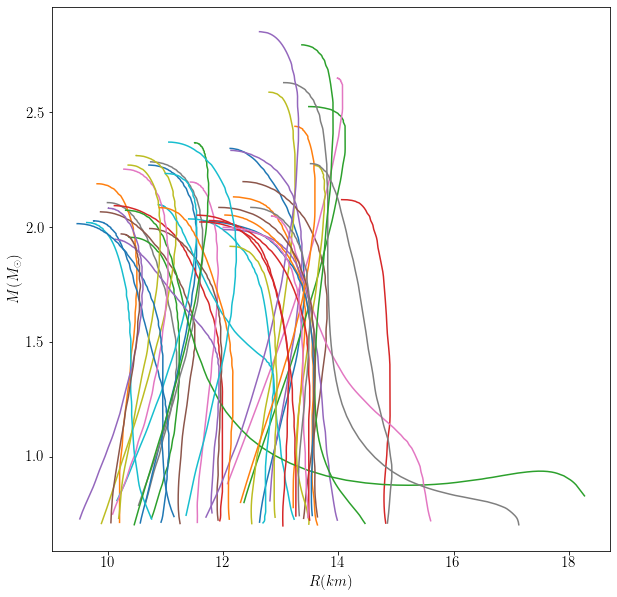

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(n_eos//10):
    ax.plot(Data[i,1], Data[i, 0]/1.477, alpha = 1)
    
plt.rcParams.update({'font.size': 15})
ax.set_xlabel(r'$R (km)$')
ax.set_ylabel(r'$M (M_{\odot})$')

147259.8239668917
294.5196479337834
[[ 0.67364482  0.67364482  0.67364482 ...  0.67364482  0.67364482
   0.67364482]
 [ 0.36089209  0.36089209  0.36089209 ...  0.36089209  0.36089209
   0.36089209]
 [21.84717707 21.84717707 21.84717707 ... 21.84717707 21.84717707
  21.84717707]
 ...
 [ 0.47542113  0.47542113  0.47542113 ...  0.47542113  0.47542113
   0.47542113]
 [ 1.07138448  1.07138448  1.07138448 ...  1.07138448  1.07138448
   1.07138448]
 [49.48040423 49.48040423 49.48040423 ... 49.48040423 49.48040423
  49.48040423]]
 active_mask: array([0., 0., 0., 0., 0., 0., 0.])
        cost: 4027.402598717932
         fun: array([-1.10653500e+00, -6.49276736e-01, -5.23886398e-01, ...,
       -5.96721473e-04, -5.95991879e-04, -5.95249888e-04])
        grad: array([ 0.00603681, -0.17064772, -0.0033684 , -0.00609132,  0.0593905 ,
        0.00246417, -0.00311951])
         jac: array([[ 2.31844427e+01, -4.68572244e+02, -6.65737223e+01, ...,
         1.47725916e+02,  2.09885746e+01,  2.98201043e+0

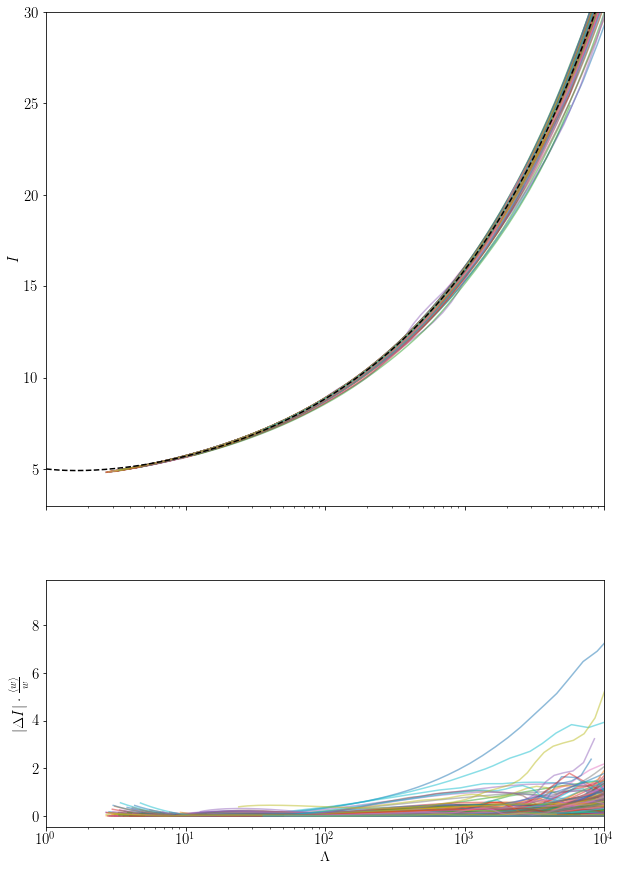

In [36]:
weight_sum = np.sum(weights)
print(weight_sum)
avg_logweight = logweight_sum / n_eos
avg_weight = weight_sum / n_eos
print(avg_weight)

fs = (lambda x,i : np.log(x)**i)
test_lambda = np.geomspace(1, 50000, 200)

sig = np.full(200,1)
sig = np.outer(np.reciprocal(weights/avg_weight),sig)
print(sig)

fig, axs = plt.subplots(2, figsize=(10, 15), gridspec_kw={'height_ratios': [2, 1]}, sharex = True)

# solution = Prediction(Data, fs, 3, 2, 5, sig)
# alpha = solution.x
# delta = np.reshape(solution.fun, (n_eos, 200))
# chi_2 = np.sum(delta**2, axis =1)
# print(solution)
# test_I = np.exp(np.sum([alpha[i] * fs(test_lambda, i) for i in range(len(alpha))], axis=0))  

x0 = [0.5313, 1.287, 0.09888, -2.300, -1.347, 0.3857, -0.02870]
I_Lambda_pred = Create_nl_Pred(2/5)
func_I_Lambda = lambda params : res(params, Data[:,2], Data[:,3], I_Lambda_pred, sig, n_eos)
sol_I_Lambda = opt.least_squares(func_I_Lambda, x0)
print(sol_I_Lambda)
delta = np.reshape(sol_I_Lambda.fun, (n_eos, 200))

axs[0].plot(test_lambda, I_Lambda_pred(sol_I_Lambda.x, test_lambda), 'k--', zorder=1000)
# sns.lineplot(ax = axs[0], x = test_lambda, y = test_I, color='black', linestyle='dashed')


for i in range(n_eos):
    axs[0].plot(Data[i,2],Data[i, 3], alpha = 0.5)
    axs[1].plot (Data[i,2], np.abs(delta[i]), alpha = 0.5)
    # sns.lineplot(ax = axs[0], x = Data[i,2], y = Data[i,3])
    # sns.lineplot(ax = axs[0], x = Data[i,2], y = np.abs(delta[i]))
    
plt.rcParams.update({'font.size': 15})

for ax in axs:
    ax.set_xscale('log')
    ax.set_xlim([1,10000])
    
axs[1].set(xlabel=r'$\Lambda$')
    
axs[0].set(ylabel=r'$I$')
axs[1].set(ylabel = r'$|\Delta I| \cdot \frac{\langle w \rangle}{w}$')

axs[0].set_ylim([3,30])
#axs[1].set_ylim(top = 2.5)

#axs[1].set_yscale('log')
#axs[0].set_yscale('log')

plt.savefig('I_vs_Lambda_np_nl_fit_weighted.pdf')

 active_mask: array([0., 0., 0., 0., 0., 0., 0.])
        cost: 1.9256934401302945
         fun: array([ 0.00053519, -0.00038525, -0.00059223, ...,  0.00508248,
        0.00506325,  0.00502639])
        grad: array([ 2.12432777e-03,  8.77584129e-04,  3.61336551e-04,  1.71524519e-04,
       -1.62712551e-04, -8.28621333e-05, -4.52353865e-05])
         jac: array([[ 2.24605875e-01,  1.28331846e+00,  1.82331087e-01, ...,
        -2.97692743e-02, -4.22955344e-03, -6.00925968e-04],
       [ 2.37221888e-01,  1.19568406e+00,  1.79267166e-01, ...,
        -3.09130567e-02, -4.63474948e-03, -6.94881268e-04],
       [ 2.50481192e-01,  1.11402488e+00,  1.76178754e-01, ...,
        -3.20785768e-02, -5.07310359e-03, -8.02292978e-04],
       ...,
       [ 1.90428414e-01,  6.45106351e-02,  3.14755673e-02, ...,
        -1.48520077e-02, -7.24648555e-03, -3.53565357e-03],
       [ 1.90461654e-01,  6.44838975e-02,  3.14710203e-02, ...,
        -1.48524531e-02, -7.24866013e-03, -3.53767014e-03],
       [ 1.

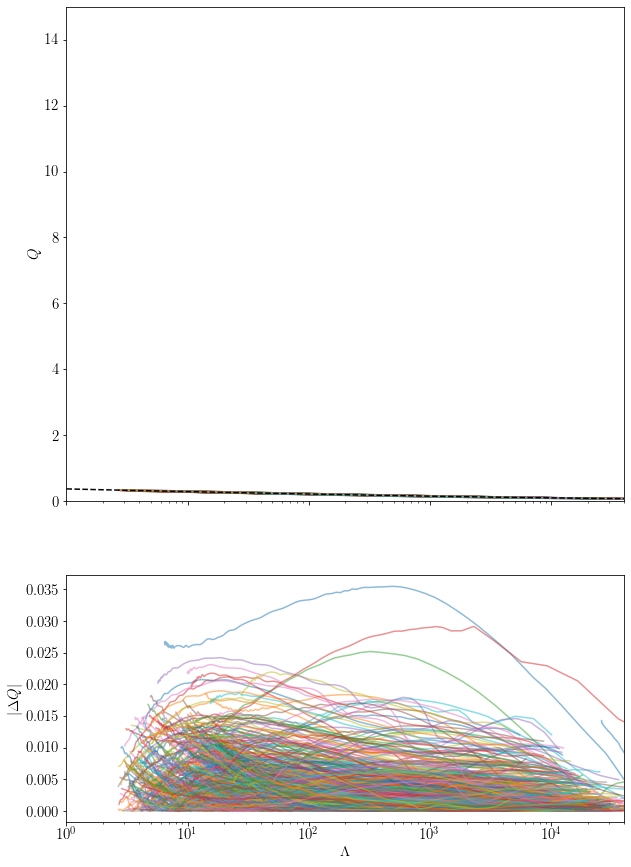

In [24]:
fs = (lambda x,i : np.log(x)**i)
sig = np.full(200,1)
test_lambda = np.geomspace(1, 100000, 200)
sig = np.outer(np.reciprocal(logweights/avg_logweight),sig)

fig, axs = plt.subplots(2, figsize=(10, 15), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# solution = Prediction_linear(Data, fs, 4, 2, 5, sig)
# alpha = solution.x
# delta = np.reshape(solution.fun, (n_eos, 200))
# chi_2 = np.sum(delta**2, axis =1)
# print(solution)
# test_Q = np.exp(np.sum([alpha[i] * fs(test_lambda, i) for i in range(len(alpha))], axis=0))
# axs[0].plot(test_lambda, test_Q, 'k--', zorder=10000)

# alpha_para = [0.2093, 0.07404, 0.05382, -5.018e-3, 1.567e-4]
# test_Q_para = np.zeros(len(test_lambda))
# test_Q_para = np.exp(np.sum([alpha_para[i] * fs(test_lambda, i) for i in range(len(alpha))], axis=0))
# axs[0].plot(test_lambda, test_Q_para, 'k-', zorder=10001)

x0 = [3.555, -2.122, 2.72, -1.491, 0.8644, -0.1428, -1.397]
Q_Lambda_pred = Create_nl_Pred(1/5)
func_Q_Lambda = lambda params : res(params, Data[:,2], Data[:,4], Q_Lambda_pred, sig, n_eos)
sol_Q_Lambda = opt.least_squares(func_Q_Lambda, x0)
print(sol_Q_Lambda)
delta = np.reshape(sol_Q_Lambda.fun, (n_eos, 200))
axs[0].plot(test_lambda, Q_Lambda_pred(sol_Q_Lambda.x, test_lambda), 'k--', zorder=1000)

for i in range(n_eos):
    axs[0].plot(Data[i,2], Data[i,4],alpha = 0.5)
    axs[1].plot (Data[i,2], np.abs(delta[i]), alpha = 0.5)
    
plt.rcParams.update({'font.size': 15})

for ax in axs:
    ax.set_xscale('log')
    ax.set_xlim([1,40000])
    
axs[1].set(xlabel=r'$\Lambda$')
    
axs[0].set(ylabel=r'$Q$')
axs[1].set(ylabel = r'$|\Delta Q|$ ')

axs[0].set_ylim([0,15])

plt.savefig('Q_vs_Lambda_nl_fit_weighted.pdf')

 active_mask: array([0., 0., 0., 0., 0., 0., 0.])
        cost: 21985.38376699112
         fun: array([-0.0625047 , -0.70374041, -0.93998225, ...,  0.21836233,
        0.21713285,  0.21493762])
        grad: array([-0.01338768, -0.00851743,  0.00315017, -0.01238079,  0.38157746,
        0.67286437,  1.16173674])
         jac: array([[ 5.76722724e-01,  8.04161362e+00,  1.32037359e+01, ...,
        -4.80101125e+02, -7.88292450e+02, -1.29431508e+03],
       [ 5.18741540e-01,  7.96099441e+00,  1.29091831e+01, ...,
        -3.77327947e+02, -6.11858916e+02, -9.92160402e+02],
       [ 4.73128085e-01,  7.93244412e+00,  1.27200893e+01, ...,
        -3.06692655e+02, -4.91798607e+02, -7.88623454e+02],
       ...,
       [ 3.43081290e-02,  3.87211255e+00,  5.19200341e+00, ...,
        -6.18436134e+00, -8.29243463e+00, -1.11190812e+01],
       [ 3.42859780e-02,  3.87361827e+00,  5.19361670e+00, ...,
        -6.17794347e+00, -8.28318189e+00, -1.11058069e+01],
       [ 3.42532722e-02,  3.87584537e+00

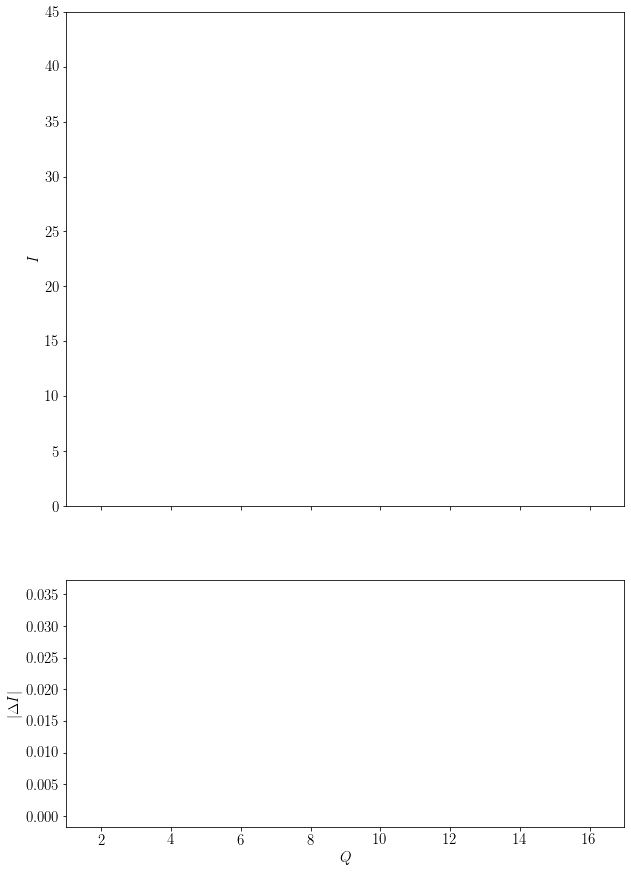

In [25]:
fs = (lambda x,i : np.log(x)**i)
sig = np.full(200,1)
test_Q = np.linspace(1, 20, 200)
sig = np.outer(np.reciprocal(logweights/avg_logweight),sig)

fig, axs = plt.subplots(2, figsize=(10, 15), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# solution = Prediction_linear(Data, fs, 3, 4, 5, sig)
# alpha = solution.x
# delta = np.reshape(solution.fun, (n_eos, 200))
# print(solution)
# test_I = np.exp(np.sum([alpha[i] * fs(test_Q, i) for i in range(len(alpha))], axis=0))
# axs[0].plot(test_Q, test_I, 'k--', zorder=10000)

x0 = [0.008921, 10.59, -37.46, 43.18, -2.361, 1.967 , -0.5678]
I_Q_pred = Create_nl_Pred(2)
func_I_Q = lambda params : res(params, Data[:,4], Data[:,3], I_Q_pred, sig, n_eos)
sol_I_Q = opt.least_squares(func_I_Q, x0)
print(sol_I_Q)
delta = np.reshape(sol_Q_Lambda.fun, (n_eos, 200))
axs[0].plot(test_Q, I_Q_pred(sol_I_Q.x, test_Q), 'k--', zorder=1000)

for i in range(n_eos):
    axs[0].plot(Data[i,4], Data[i,3], alpha = 0.5)
    axs[1].plot (Data[i,4], np.abs(delta[i]), alpha = 0.5)
    
plt.rcParams.update({'font.size': 15})

for ax in axs:
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xlim([1,17])
    
axs[1].set(xlabel=r'$Q$')
    
axs[0].set(ylabel=r'$I$')
axs[1].set(ylabel = r'$|\Delta I|$ ')

axs[0].set_ylim([0,45])

plt.savefig('I_vs_Q_np_nl_fit_weighted.pdf')

 active_mask: array([0., 0., 0., 0., 0., 0., 0.])
        cost: 1.7594001629629883
         fun: array([ 6.35302085e-04, -1.28473498e-05, -2.06939588e-04, ...,
        3.92028954e-03,  3.96217872e-03,  4.00077888e-03])
        grad: array([-7.82518043e-03,  3.77221967e-06,  1.85737439e-06,  9.74473717e-07,
       -7.79578978e-06, -3.75323919e-06, -1.93301113e-06])
         jac: array([[ 3.51140156e-01, -2.51871555e-04, -3.57850147e-05, ...,
         6.22497409e-04,  8.84422228e-05,  1.25655555e-05],
       [ 3.70840792e-01, -2.66130237e-04, -3.99001749e-05, ...,
         6.58265522e-04,  9.86919482e-05,  1.47966119e-05],
       [ 3.91354089e-01, -2.80853182e-04, -4.44155097e-05, ...,
         6.95014615e-04,  1.09913044e-04,  1.73821901e-05],
       ...,
       [ 1.18633876e+00, -4.55271219e-04, -2.89442392e-04, ...,
         8.49546158e-04,  5.40105906e-04,  3.43376723e-04],
       [ 1.18694960e+00, -4.55054421e-04, -2.89537963e-04, ...,
         8.48893922e-04,  5.40126662e-04,  3.43

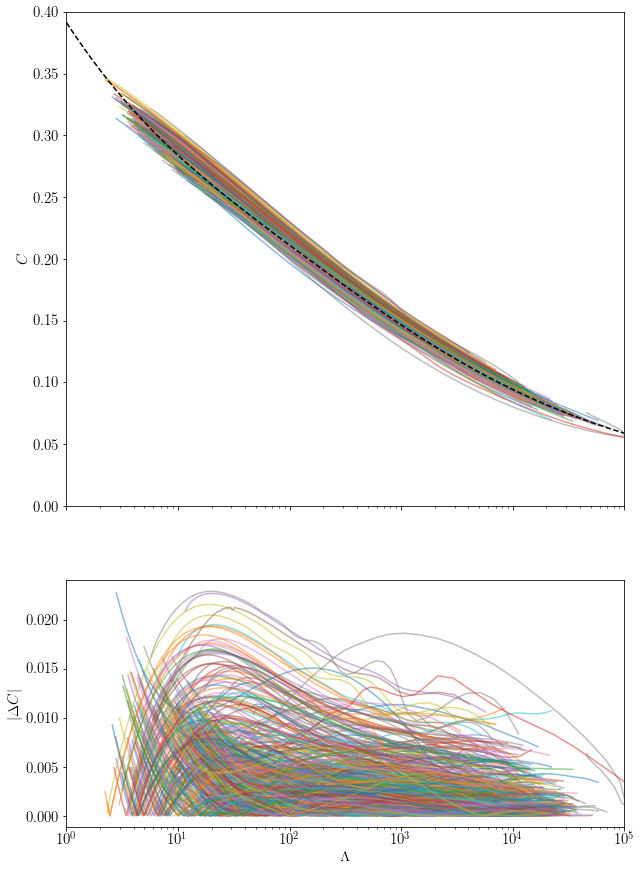

In [41]:
fs = (lambda x,i : np.log(x)**i)
sig = np.full(200,1)
test_lambda = np.geomspace(1, 100000, 200)
sig = np.outer(np.reciprocal(logweights/avg_logweight),sig)

fig, axs = plt.subplots(2, figsize=(10, 15), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

# solution = Prediction_linear(Data, fs, 5, 2, 3, sig, False)
# alpha = solution.x
# delta = np.reshape(solution.fun, (n_eos, 200))
# print(solution)
# test_C = np.sum([alpha[i] * fs(test_lambda, i) for i in range(len(alpha))], axis=0) 
# axs[0].plot(test_lambda, test_C, 'k--', zorder=1000)

x0 = [0.2496, -919.6, 330.3, -857.2, -383.5, 192.5, -811.1]
C_Lambda_pred = Create_nl_Pred(-1/5)
func_C_Lambda = lambda params : res(params, Data[:,2], Data[:,5], C_Lambda_pred, sig, n_eos)
sol_C_Lambda = opt.least_squares(func_C_Lambda, x0)
print(sol_C_Lambda)
delta = np.reshape(sol_C_Lambda.fun, (n_eos, 200))
axs[0].plot(test_lambda, C_Lambda_pred(sol_C_Lambda.x, test_lambda), 'k--', zorder=1000)

for i in range(n_eos):
    axs[0].plot(Data[i,2],Data[i, 5], alpha = 0.5)
    axs[1].plot (Data[i,2], np.abs(delta[i]), alpha = 0.5)
    
plt.rcParams.update({'font.size': 15})

for ax in axs:
    ax.set_xscale('log')
    ax.set_xlim([1,100000])
    
axs[1].set(xlabel=r'$\Lambda$')
    
axs[0].set(ylabel=r'$C$')
axs[1].set(ylabel = r'$|\Delta C| $')

axs[0].set_ylim([0,0.4])

plt.savefig('C_vs_Lambda_np_nummoi_0_nl_fit.pdf')

 active_mask: array([0., 0., 0.])
        cost: 7413.512378130705
         fun: array([-0.8361689 , -0.38951472, -0.13105052, ...,  0.01752197,
        0.01843377,  0.01929928])
     message: 'The unconstrained solution is optimal.'
         nit: 0
  optimality: 1.793705450836569e-08
      status: 3
     success: True
           x: array([ 7.53122948, -0.59946804,  0.23275365])


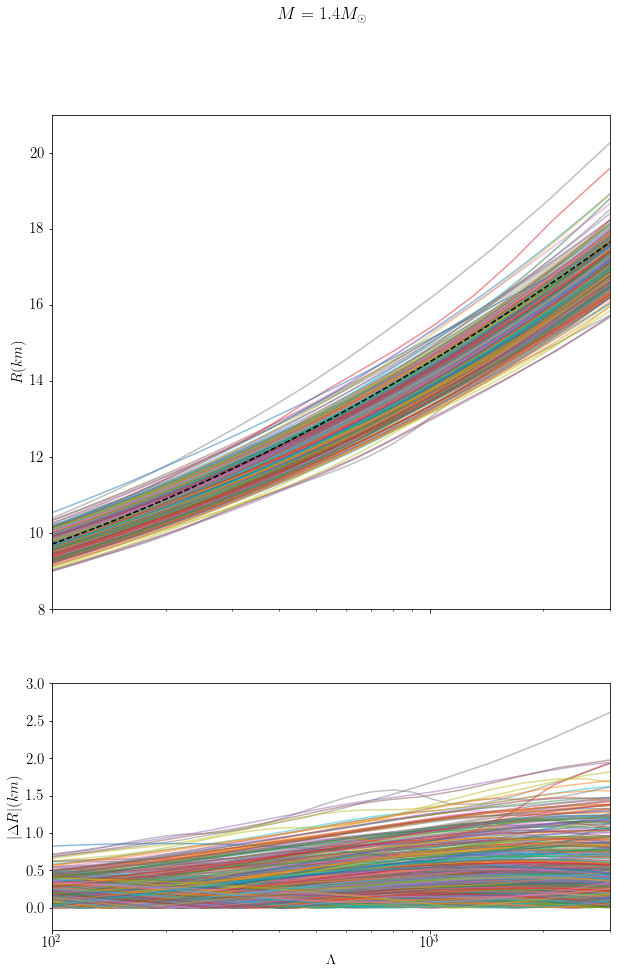

In [286]:
fs = (lambda x,i : np.log(x)**i)
sig = np.full(200,1)

Point_M = 1.4 * 1.477

R_new = np.reciprocal(Data[:,5,:]/Point_M)

Data[:,1,:] = R_new

# solution = Prediction_linear(Data, fs, 1, 2, 3, sig, False)
# alpha = solution.x
# delta = np.reshape(solution.fun, (n_eos, 200))
# print(solution)

fig, axs = plt.subplots(2, figsize=(10, 15), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

test_Lambda = np.geomspace(1, 100000, 200)
test_R = np.zeros(len(test_lambda))
test_R = np.sum([alpha[i] * fs(test_Lambda, i) for i in range(len(alpha))], axis=0)

axs[0].plot(test_Lambda, test_R, 'k--', zorder=10000)

lam = np.zeros(n_eos)
rad = np.zeros(n_eos)

for i in range(n_eos):
    axs[0].plot(Data[i,2], Data[i,1], alpha = 0.5)
    axs[1].plot (Data[i,2], np.abs(delta[i]), alpha = 0.5)
    
    m_idx1, m_idx2 = find_nearest(Data[i,0], Point_M)
    lam[i] = lam_interp(m_idx1, m_idx2, Data[i,2], Data[i,0], Point_M)
    rad[i] = lam_interp(m_idx1, m_idx2, Data[i,1], Data[i,0], Point_M)

#axs[0].scatter(lam, rad, color = 'red', zorder=1000000)
    
for ax in axs:
    ax.set_xscale('log')
    axs[0].set_xlim([100,3000])
    
plt.rcParams.update({'font.size': 15})

axs[1].set(xlabel=r'$\Lambda$')
    
axs[0].set(ylabel=r'$R (km)$')
axs[1].set(ylabel = r'$|\Delta R| (km)$ ')

axs[0].set_ylim([8,21])
axs[1].set_ylim(top = 3)

plt.suptitle(r'$M = 1.4 M_{\odot}$')

plt.savefig('R_vs_Lambda_np_nummoi_0_ M_1.4.pdf')

In [336]:
import subprocess 

p = subprocess.run("whoami")
p = subprocess.run("hostname")


oscar.sy-garcia
ldas-pcdev5


In [23]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    return(idx-1, idx)
def lam_interp(idx1, idx2, lam_data, mass_data, m_goal):
    part_lam = lam_data[idx2] - lam_data[idx1]
    part_mass = mass_data[idx2] - mass_data[idx1]
    del_mass = m_goal - mass_data[idx1]
    slope = part_lam/part_mass
    lam = lam_data[idx1] + slope * del_mass
    return(lam)

#finds all viable Lambda_a and Lambda_s data for all EoS models
def Lambda_a_s(Data, q, Mass_idx,Lambda_idx):
    #collecting relevant mass and lamnda data
    Mass_Data = Data[:,Mass_idx,:]
    Lambda_Data = Data[:,Lambda_idx,:]
    
    #findind number of EoS to analyze and constructing returns
    n_eos = len(Mass_Data)
    Lambda_A_tot = np.empty((n_eos, 200))
    Lambda_S_tot = np.empty((n_eos, 200))
    
    for i in range(n_eos):
        #create list of all values for this EoS
        lam_a = []
        lam_s = []
        
        #Find minimum value index for the mass in EoS model to compare M2 with
        M_min_idx = np.argmin(Mass_Data[i,:])
        
        j = 0
        #Going down the array of Mass, starting from the highest, calculate Lambda1 and Lambda2 if M2 is larger than our minimum value present in EoS
        while (Mass_Data[i,-1-j]*q >= Mass_Data[i, M_min_idx]):
            #Find M1s respective Lambda
            m1_idx = -1 - j
            lam_1 = Lambda_Data[i, m1_idx]
            
            #Calculate M2 and its nearest indeces within our EoS
            m2_goal = q * Mass_Data[i,m1_idx]
            m2_idx1, m2_idx2 = find_nearest(Mass_Data[i], m2_goal)

            #Find M2s respective lambda through a small interpolation
            lam_2 = lam_interp(m2_idx1, m2_idx2, Lambda_Data[i], Mass_Data[i], m2_goal)
            
            #Calculate both Lambda_a and Lambda_s and add them to our list
            lam_a.append(np.abs((lam_1 - lam_2)*0.5))
            lam_s.append((lam_1 + lam_2)*0.5)
            j += 1

        lam_s = np.array(lam_s)
        lam_a = np.array(lam_a)
            
        if np.any(lam_s <= 0):
            raise ValueError('Lambda_S goes below 0')
                
        if np.size(lam_s) == 0:
            print(Mass_Data[i, :])
            raise ValueError('Lambda_S is empty')
               
        #Interpolate Lambda_a and Lambda_s to make sure all data is 200 points
        lam_A_of_lam_S = inter.interp1d(lam_s, lam_a, 'cubic')
        lam_s = np.geomspace(lam_s[0], lam_s[-1], 200)
        lam_a = lam_A_of_lam_S(lam_s)
        
        #Add found data to our 2d array documenting data for all EoS
        Lambda_A_tot[i] = np.array(lam_a)
        Lambda_S_tot[i] = np.array(lam_s)    

    return(Lambda_A_tot, Lambda_S_tot)

def F_of_q(q, n):
    return((1 - q**(10/(3-n)))/(1 + q**(10/(3-n))))

def Create_qPred(q, n, alpha):
    Fnq = F_of_q(q, n)
    def pred(param, lambda_s):
        b_matrix = np.reshape(param[:6], (3, 2))
        c_matrix = np.reshape(param[6:], (3, 2))
        return ((Fnq * ( (1 + np.sum(np.array([[b_matrix[i,j] * q**j * lambda_s**(- i / 5) for i in range(3)] for j in range(2)]), axis = (0,1)))
                  / (1 + np.sum(np.array([[c_matrix[i,j] * q**j * lambda_s**(- i / 5) for i in range(3)] for j in range(2)]), axis = (0,1))) ) 
               * lambda_s**alpha))
    return (pred)

In [251]:
lam_a_5, lam_s_5 = Lambda_a_s(Data, 0.5, 0, 2)
lam_a_75, lam_s_75 = Lambda_a_s(Data, 0.75, 0, 2)
lam_a_9, lam_s_9 = Lambda_a_s(Data, 0.9, 0, 2)

In [272]:
sig_50 = np.geomspace(100, 10000, 200)
sig_75 = np.geomspace(80, 5000, 200)
sig_90 = np.geomspace(20, 1000, 200)

x0 = [-14.4, 14.45, 31.36, -32.25, -22.44, 20.35, -15.25, 15.37, 37.33, -43.20, -29.93, 35.18]

n = 0.743
alpha = 1

q_50_pred = Create_qPred(0.50, n, alpha)
q_75_pred = Create_qPred(0.75, n, alpha)
q_90_pred = Create_qPred(0.90, n, alpha)

# The functions to be minimized w/ respect to params
func_50 = lambda params : res(params, lam_s_5, lam_a_5, q_50_pred, sig_50, n_eos)
func_75 = lambda params : res(params, lam_s_75, lam_a_75, q_75_pred,sig_75, n_eos)
func_90 = lambda params : res(params, lam_s_9, lam_a_9, q_90_pred, sig_90, n_eos)

sol_q50 = opt.least_squares(func_50, x0)
sol_q75 = opt.least_squares(func_75, x0)
sol_q90 = opt.least_squares(func_90, x0)


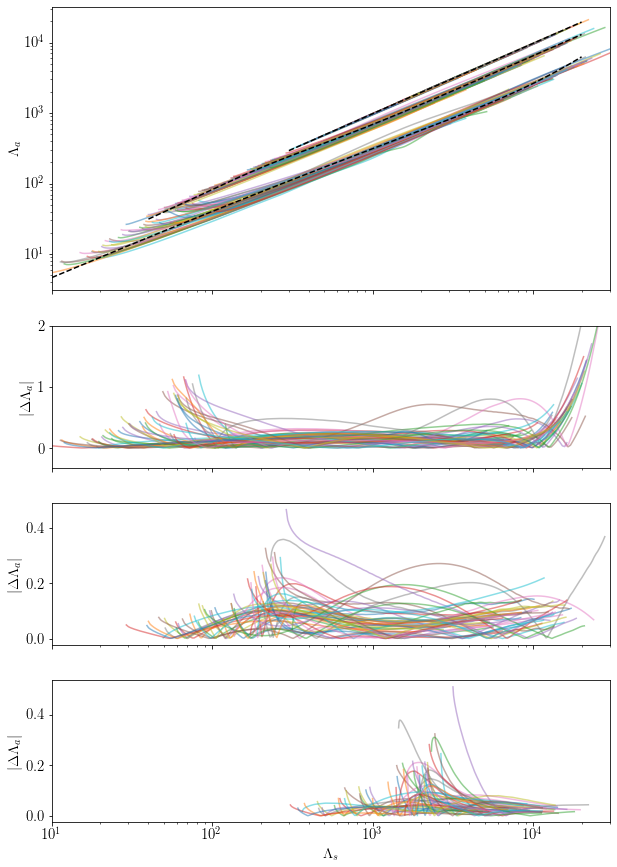

In [287]:
fig, axs = plt.subplots(4, figsize=(10, 15), gridspec_kw={'height_ratios': [2, 1, 1, 1]}, sharex=True)

delta_q50 = np.reshape(sol_q50.fun, (n_eos, 200))
delta_q75 = np.reshape(sol_q75.fun, (n_eos, 200))
delta_q90 = np.reshape(sol_q90.fun, (n_eos, 200))

test_lam_s_q50 = np.geomspace(300, 20000, 200)
test_lam_s_q75 = np.geomspace(40, 20000, 200)
test_lam_s_q90 = np.geomspace(10, 20000, 200)

for i in range(n_eos//10):
    axs[0].plot(lam_s_5[i], lam_a_5[i], alpha = 0.50)
    axs[0].plot(lam_s_75[i], lam_a_75[i], alpha = 0.50)
    axs[0].plot(lam_s_9[i], lam_a_9[i], alpha = 0.50)
    
    axs[3].plot (lam_s_5[i], np.abs(delta_q50[i]), alpha = 0.50)
    axs[2].plot (lam_s_75[i], np.abs(delta_q75[i]), alpha = 0.50)
    axs[1].plot (lam_s_9[i], np.abs(delta_q90[i]), alpha = 0.50)
    
axs[0].plot(test_lam_s_q90, q_90_pred(sol_q90.x, test_lam_s_q90), 'k--', zorder = 10000)    
axs[0].plot(test_lam_s_q75, q_75_pred(sol_q75.x, test_lam_s_q75), 'k--', zorder = 10000)    
axs[0].plot(test_lam_s_q50, q_50_pred(sol_q50.x, test_lam_s_q50), 'k--', zorder = 10000) 

for ax in axs:
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xlim([10,30000])

    
plt.rcParams.update({'font.size': 15})

axs[3].set(xlabel=r'$\Lambda_s$')
    
axs[0].set_yscale('log')

axs[0].set(ylabel=r'$\Lambda_a$')
axs[1].set(ylabel = r'$|\Delta \Lambda_a|$')
axs[1].set_ylim(top = 2)
axs[2].set(ylabel = r'$|\Delta \Lambda_a|$')
axs[3].set(ylabel = r'$|\Delta \Lambda_a|$')


# axs[0].set_ylim([8,21])
# axs[1].set_ylim([-0.05,3])

plt.savefig('Lambdaa_vs_Lambdas_np_nummoi_0.pdf')

In [ ]:
# fig, ax = plt.subplots()
# for i in range(50):
#     ax.plot(Data[i,2],Data[i, 4])
    
# def test_C(lam):
#     Compact1 = np.zeros(len(lam))
#     Compact2 = np.zeros(len(lam))
#     for i in range(len(lam)):
#         Compact1[i] = 0.371 - (0.0391 * (np.log(lam[i]))) + (0.001056 * (np.log(lam[i]))**2)
#         Compact2[i] = 0.360 - (0.0355 * (np.log(lam[i]))) + (0.000705 * (np.log(lam[i]))**2)
#     return(Compact1, Compact2)
# test_lambda = np.linspace(1, 10000, 500)
# test_C1, test_C2 = test_C(test_lambda)
# ax.plot(test_lambda, test_C1, 'k--', zorder=100)
# ax.plot(test_lambda, test_C2, 'k-', zorder=100)
    
# ax.set(xlabel=r'$\Lambda', ylabel=r'C')
# ax.set_xscale('log')
# #ax.set_ylim([0.05, 0.32])
# #ax.set_xlim([1,10000])
# ax.grid(True, which = 'both')
# plt.savefig('C-vs-Lambda.pdf')

In [140]:
# fig, ax = plt.subplots()
# for i in range(50):
#     ax.plot(Data[i,4]*1.477,a_c[i])
# ax.set(xlabel='C', ylabel=r'$\alpha_c$')
# ax.set_xlim(left = 0.05)
# ax.set_yscale('log')
# ax.set_ylim([0.017,4])
# ax.grid(True, which = 'both')
# plt.savefig('alpha_c-vs-C')


2.3065009260633953e-44

In [ ]:
# fig, ax = plt.subplots()
# for i in range(50):
#     ax.plot(Data[i,2],Data[i, 1])
# ax.set(xlabel=r'$\Lambda$', ylabel=r'R (km)')
# ax.set_xscale('log')
# #ax.set_ylim([0.05, 0.32])
# ax.set_xlim([1,10000])
# ax.grid(True, which = 'both')
# plt.savefig('R-vs-Lambda')

In [ ]:
# fig, ax = plt.subplots()
# for i in range(50):
#     ax.plot(Data[i,1],Data[i, 0])
# ax.set(xlabel=r'R (km)', ylabel=r'Mass (Msun)')
# #ax.set_ylim([0.05, 0.32])
# #ax.set_xlim([1,10000])
# ax.grid(True, which = 'both')
# plt.savefig('M-vs-R')

In [7]:
def param_overall(FullData, predict_forms, idx1, idx2, n_param, sigma):
    n_eos = len(FullData)
    
    param_overall = np.empty((n_eos,n_param))
    var_dep = FullData[:,idx1,:]/sigma #data to acheieve
    var_ind = FullData[:,idx2,:]
    for i in range(n_eos):
        matrix = np.array([(predict_forms(var_ind[i,:],j)/sigma) for j in range(n_param)])
        sol = opt.lsq_linear(np.transpose(matrix),var_dep[i,:])
        param_overall[i,:] = sol.x
    return (param_overall)

In [398]:
#subData = Data[1]
#sol = Prediction(subData, fs, 4, 2, 3, sig)
#print(sol.x)

# param_overall = np.empty((500,3))
# for i in range(500):
#     subData = Data[i]
#     sol = Prediction(subData, fs, 4, 2, 3, sig)
#     param_overall[i,:] = sol.x
#     print(sol.fun)
# np.average(param_overall,axis=0)


# fs = (lambda x,i : np.log(x)**i)
# sig = np.full(200,0.001)

# solution = Prediction(Data, fs, 'C', 'Lambda', 3, sig, True)
# print(solution.x)

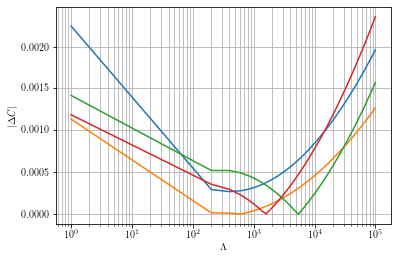

In [105]:
fig, ax = plt.subplots()

test_lambda = np.linspace(1, 100000, 500)
test_C1 = np.zeros(len(test_lambda))
test_C2 = np.zeros(len(test_lambda))
test_C3 = np.zeros(len(test_lambda))
test_C4 = np.zeros(len(test_lambda))
test_C5 = np.zeros(len(test_lambda))
for i in range(len(test_lambda)):
    test_C1[i] = 0.36621088 - (0.03787991 * (np.log(test_lambda[i]))) + (0.00088979 * (np.log(test_lambda[i]))**2)
    test_C2[i] = 0.36845603 - (0.03854036 * (np.log(test_lambda[i]))) + (0.00094501 * (np.log(test_lambda[i]))**2)
    test_C3[i] = 0.36734559 - (0.03829281 * (np.log(test_lambda[i]))) + (0.00092667 * (np.log(test_lambda[i]))**2)
    test_C4[i] = 0.36762851 - (0.03856961 * (np.log(test_lambda[i]))) + (0.00095086 * (np.log(test_lambda[i]))**2)
    test_C5[i] = 0.36739782 - (0.038507 * (np.log(test_lambda[i]))) + (0.00095309 * (np.log(test_lambda[i]))**2)
    
ax.plot(test_lambda, np.abs(test_C2 - test_C1))
ax.plot(test_lambda, np.abs(test_C3 - test_C1))
ax.plot(test_lambda, np.abs(test_C4 - test_C1))
ax.plot(test_lambda, np.abs(test_C5 - test_C1))

ax.set(xlabel=r'$\Lambda$', ylabel=r'$|\Delta C|$')
ax.set_xscale('log')
ax.grid(True, which = 'both')
plt.savefig('C-vs-Lambda_fit.pdf')

In [91]:
def M_of_Lambda(C_L_param, Lambda, fs):
    Mparam = (C_L_param * 12)/1.477
    Mass = np.sum([Mparam[i]*fs(Lambda,i) for i in range(len(C_L_param))],axis = 0) 
    return(Mass)

In [40]:
Lambda = np.geomspace(10,10000,100)
M = M_of_Lambda(solution.x, Lambda, fs)

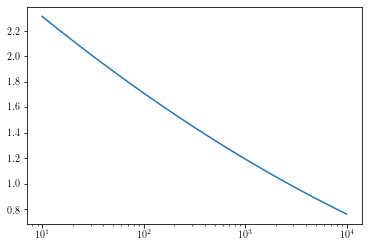

In [36]:
fig, ax = plt.subplots()
ax.plot(Lambda, M)
ax.set_xscale('log')

In [92]:
M_op = M_of_Lambda(solution.x , 500, fs)

In [93]:
bilby.gw.conversion.component_masses_to_chirp_mass(M_op,M_op)

1.166324158248777

In [94]:
Lambda = [20,30,50,200,300,500,700,1000]
M_chirp = np.empty(len(Lambda))
for i,o in enumerate(Lambda):
    M_op = M_of_Lambda(solution.x, o, fs)
    M_chirp[i] = bilby.gw.conversion.component_masses_to_chirp_mass(M_op,M_op)
M_chirp

array([1.84314752, 1.75020179, 1.63625928, 1.34476732, 1.26440874,
       1.16632416, 1.10363932, 1.03885729])

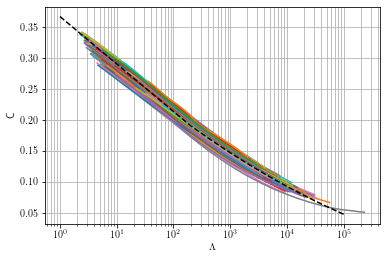

In [78]:
fig, ax = plt.subplots()
for i in range(500):
    ax.plot(Data[i,2],Data[i, 4])
test_lambda = np.linspace(1, 100000, 500)
test_C = np.zeros(len(test_lambda))
for i in range(len(test_lambda)):
    test_C[i] = 0.36621088 - (0.03787991 * (np.log(test_lambda[i]))) + (0.00088979 * (np.log(test_lambda[i]))**2)
ax.plot(test_lambda, test_C, 'k--', zorder=1000)
ax.set(xlabel=r'$\Lambda$', ylabel=r'C')
ax.set_xscale('log')
ax.grid(True, which = 'both')
plt.savefig('C-vs-Lambda.pdf')

In [100]:
print((const.c**4/(const.G**2 * u.kg**3))*((1000 * u.kg * u.m**2)/(u.g * 100 * u.cm**2)))

1.8133071098665124e+55 1 / (cm2 g)


In [99]:
print(const.c**4/(const.G**2 * u.kg**3))

1.8133071098665124e+54 1 / (kg m2)
